In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

count
 14 
fluxes
 [100797.05  106257.11  116872.79   87503.92   91506.3    81874.305
  72059.74   79520.414  87435.914  96973.984  75458.95   92792.305
  67921.875  86710.71       0.         0.         0.         0.
      0.         0.   ] 
locs
 [[12.961029   15.245459  ]
 [25.41292     3.0066495 ]
 [ 3.319416   20.902977  ]
 [22.779491   16.23555   ]
 [28.185198   13.637561  ]
 [14.734232    1.6591041 ]
 [27.226007   22.62667   ]
 [ 4.842591   19.068583  ]
 [12.334013   23.60637   ]
 [ 0.6058543   0.96637464]
 [18.533375   25.62587   ]
 [10.132242   29.0871    ]
 [21.580875   29.24226   ]
 [22.545166   20.3383    ]
 [-0.          0.        ]
 [ 0.          0.        ]
 [ 0.         -0.        ]
 [ 0.          0.        ]
 [-0.          0.        ]
 [ 0.          0.        ]] 




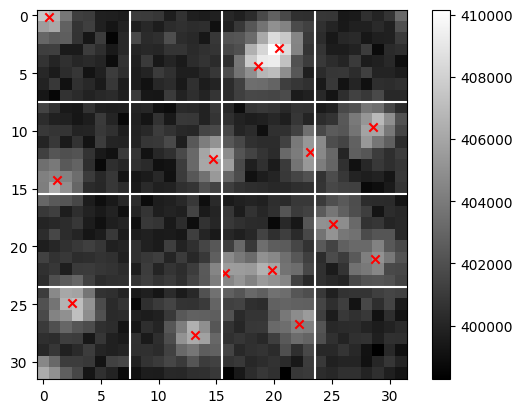

In [2]:
image_dim = 32
true_psf_stdev = 1.5
true_background = 400000
true_flux_mean = 80000
true_flux_stdev = 15000

TruePrior = StarPrior(max_objects = 20,
                      image_height = image_dim,
                      image_width = image_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f"count\n", true_counts[0].round().item(),
      "\nfluxes\n", true_fluxes[0].cpu().numpy(),
      "\nlocs\n", true_locs[0].cpu().numpy(), "\n\n")
fig, img = plt.subplots(1,1)
tmp = img.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = img.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = img.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

We'll assume that the image background, PSF standard deviation, and flux prior parameters are all known.

In [3]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 4,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MHKernel = MetropolisHastings(num_iters = 75,
                              locs_stdev = 0.1,
                              features_stdev = 1000,
                              features_min = 50000,
                              features_max = 110000)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [4]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 1000,
                 ess_threshold = 800,
                 max_smc_iters = 100)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)

True count: 14
True total flux: 1243685.375

Starting the tile samplers...
iteration 5, temperature = 0.0077107371762394905
iteration 10, temperature = 0.029308609664440155
iteration 15, temperature = 0.09152088314294815
iteration 20, temperature = 0.27124398946762085
iteration 25, temperature = 0.7020880579948425
Done!



Now we instantiate an `Aggregate` object with the tile-level results from above:

In [5]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.features,
                smc.weights_intercount)

We run the aggregation procedure to obtain image-level catalogs:

In [6]:
agg.run()

We compute the posterior mean number of light sources:

In [7]:
agg.posterior_mean_counts

tensor([[14.]], device='cuda:5')

And we compute the posterior mean total flux:

In [8]:
agg.posterior_mean_total_flux

tensor([[1263413.5000]], device='cuda:5')

Finally, we reconstruct the image using one of the catalogs we just sampled:

tensor([[[12.9274, 15.3021],
         [ 0.5281,  0.9131],
         [22.8336, 16.5407],
         [25.4479,  3.1218],
         [ 3.0243, 20.9089],
         [27.0304, 22.5153],
         [21.8053, 29.3576],
         [12.4269, 23.5689],
         [22.4322, 20.3047],
         [10.1101, 28.8718],
         [28.2168, 13.6016],
         [14.8565,  1.5109],
         [ 4.7867, 19.3361],
         [18.6462, 25.5376],
         [-0.0000,  0.0000],
         [ 0.0000,  0.0000]]], device='cuda:5')
tensor([[105870.6328, 102723.4609,  79250.4766, 104012.1094, 104304.3828,
          74742.2422,  70183.9297,  84079.4531,  89897.0859, 100105.5469,
          86928.4531,  88457.6328,  97699.1484,  75248.7578,      0.0000,
              0.0000]], device='cuda:5')


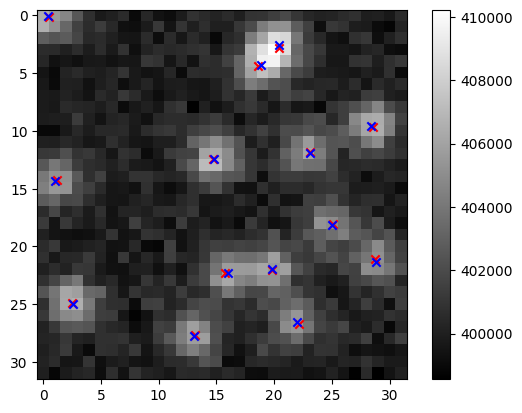

In [9]:
index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
print(agg.locs.squeeze()[index])
print(agg.features.squeeze()[index])
psf = agg.ImageModel.psf(agg.locs[:,:,index])
rate = (psf * agg.features[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
_ = plt.imshow(reconstruction[0].cpu(), cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = plt.scatter(agg.locs.squeeze()[index,:agg.counts.squeeze()[index],1].cpu() - 0.5,
                agg.locs.squeeze()[index,:agg.counts.squeeze()[index],0].cpu() - 0.5, marker = 'x', color = 'blue')